# Previsão de Resultados Exatos em Jogos de Futebol Europeu

***
Tema 4C, 28/05/2020

* João Alberto Preto Rodrigues Praça, up201704748@fe.up.pt 
* Liliana Natacha Nogueira de Almeida, up201706908@fe.up.pt	
* Silvia Jorge Moreira da Rocha, up201704684@fe.up.pt

Faculdade de Engenharia da Universidade do Porto <br/>
Mestrado Integrado em Engenharia Informática e Computação, Inteligência Artificial


#### Resumo

Neste artigo são abordados diferentes métodos de aprendizagem computacional, mais especificamente de aprendizagem supervisionada, na resolução de problemas de regressão. O problema em particular abordado é o de cálculo de resultados exatos para jogos de futebol europeu, tendo por base o dataset fornecido. Existe uma fase inicial de pré-processamento dos dados (que engloba a limpeza e exploração dos dataset fornecido), seguida pela aplicação dos seguintes algoritmos: Linear Regression, K-nearest Neighbour, Decision Trees, Neural Networks e Support Vector Machines. Após testar estes algoritmos, com diferentes parametrizações, concluiu-se que aquele que apresenta melhores resultados é o Decision Trees seguido do K-nearest Neighbour.


### 1. Introdução

O objetivo deste projeto é resolver um problema de regressão, nomeadamente a previsão de resultados exatos em jogos de futebol europeu, através da aplicação de diferentes métodos de Machine Learning, mais especificamente de aprendizagem supervisionada. 

Machine Learning é uma área da inteligência artificial que permite a um sistema computacional aprender através do reconhecimento de padrões, melhorando progressivamente a performance numa tarefa específica, sem ser programada especificamente para o efeito. 

Neste artigo iremos focar-nos na aprendizagem supervisionada que se baseia no mapeamento de inputs em outputs através do treino de um modelo. Deste modo, são fornecidos dados ao sistema, juntamente com o output desejado, de forma a ensiná-lo e ajudá-lo na identificação de padrões. Esta fase de treino irá permitir a criação de um modelo capaz de prever outputs para novos inputs daquele tipo.

O problema abordado neste documento é de regressão dado que as variáveis a prever (número de golos da equipa da casa e da equipa de fora) são valores reais.

### 2. Descrição do problema e dataset

Este dataset tem informações básicas sobre o jogo (qual o país, época, liga, jornada, data, os jogadores em campo, as suas posições, número de golos), estatísticas da FIFA acerca dos jogadores (um rating geral, o potencial, altura, peso, entre outros) e das equipas (build-up através de passes, build-up através de dribles, pressão defensiva, pressão ofensiva, criação de passes e remates, entre outros) e dados de odds provenientes de diversas casas de apostas.

O problema de regressão em causa consiste na previsão do número de golos das duas equipas para um determinado jogo. 


### 3. Abordagem 

Tendo em conta a constituição do dataset, já descrita anteriormente, foram seguidos os seguintes passos na fase de seleção de dados:

* Na tabela relativa aos atributos de uma dada equipa, decidimos compilar todos os dados fornecidos através da média ponderada dos valores de build-up através de velocidade, build-up através de drible, build-up através de passes, pressão defensiva, pressão ofensiva e largura da defesa, tendo sido atribuído um maior peso aos valores relacionados com a defesa. 
* Na tabela relativa aos atributos de um jogador não foram utilizados nenhuns dados, uma vez que o dataset é composto por informação proveniente da FIFA e, portanto, a pontuação da equipa num dado momento é uma média ponderada dos seus jogadores. Deste modo, a utilização destes dados iria acrescentar complexidade e redundância sem melhorar os resultados obtidos.
* Na tabela relativa aos jogos, foram utilizados os golos da equipa da casa, da equipa de fora e uma média ponderada das odds das casas de apostas. Nesta média, foram excluídas algumas casas que apresentavam uma elevada percentagem de dados com valores omissos.
* As restantes tabelas foram apenas utilizadas para unir estas informações dado que não apresentavam mais nenhum dado relevante.

De seguida, efetuámos o pré-processamento destes dados. Nesta fase, os dados omissos foram uniformizados e, posteriormente, foram removidas todas as linhas que os incluíam. A opção de eliminar linhas com dados omissos, ao invés de os substituir por outros valores (como por exemplo a média de valores da coluna), assenta em dois motivos: a elevada dimensão do dataset permite que a perda de alguns dados não se demonstre relevante e a aplicação de operações usando todos os dados válidos de uma coluna (como por exemplo a de odds) não permitiria a obtenção de um valor próximo daquele que seria o valor real, uma vez que para cada jogo as equipas participantes são diferentes e portanto os dados dessa coluna não têm relação entre si.

Após isto, surge a fase de transformação. Nesta fase foi aplicada a normalização sobre os valores das variáveis a serem utilizadas pelos algoritmos de cálculo de regressão.


Finalmente, surge a fase de aplicação dos algoritmos já mencionados. 



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import sqlite3
from sklearn import preprocessing
import missingno as msno # uncomment if display_nan_graph is True
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, max_error
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.graphics.correlation import plot_corr
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor # Nearest Neighbors Algorithm
from sklearn.neural_network import MLPRegressor # Neural network Algorithm
from sklearn import svm # Support Vector Machines Algorithm
from sklearn import tree # Decision Trees Algorithm

In [2]:
con = sqlite3.connect("./database.sqlite")
display_nan_graph = True
cross_validation = False

def clean_data(data):
    # This line displays the NaN distribution before data clean up
    if display_nan_graph:
        msno.matrix(data)
    data = data.replace("", np.NaN)
    data = data.dropna()
    if display_nan_graph:
        msno.matrix(data)
    return data

def preprocess_data() :
    # Get matches' info
    matches = pd.read_sql_query('SELECT *, strftime("%Y",date) as year, (B365H + BWH + IWH + LBH + WHH +  VCH )/6 AS home_odds, (B365D + BWD + IWD + LBD + WHD + VCD)/6 AS draw_odds,  (B365A + BWA + IWA + LBA + WHA + VCA )/6 AS away_odds FROM match',con)
    matches = matches.iloc[:, np.r_[0,2,4,7,8,9,10, 55:77, 115:119 ]]
    
    # Get teams' info
    teams = pd.read_sql_query('SELECT team_api_id, (buildUpPlaySpeed * 0.11 + buildUpPlayDribbling * 0.11 + buildUpPlayPassing * 0.11 + defencePressure *0.23 + defenceAggression * 0.22 + defenceTeamWidth * 0.22) as team_rating FROM team_attributes', con)
    
    # Get players' info
    players = pd.read_sql_query('SELECT player_api_id, strftime("%Y",date) as year, avg(potential) as player_potential, avg(overall_rating) as rating FROM player_attributes GROUP BY player_api_id, year', con)
    
    # Clean up data
    matches = clean_data(matches)
    teams = clean_data(teams)
    players = clean_data(players)
      
    # Merge data tables
    result = pd.merge(matches, teams, left_on='home_team_api_id', right_on='team_api_id', how='left').drop('team_api_id', axis=1)
    result = pd.merge(result, teams, left_on='away_team_api_id', right_on='team_api_id', how='left').drop('team_api_id', axis=1)
    result.rename(columns={"team_rating_x": "home_team_rating", "team_rating_y": "away_team_rating"}, inplace=True)

    for player_index in range(1,12):
        player_home_id = "home_player_" + str(player_index)
        player_away_id = "away_player_" + str(player_index)
        result = pd.merge(result, players, left_on=[player_home_id, 'year'], right_on=['player_api_id', 'year'], how='left').drop(['player_api_id', player_home_id], axis=1)
        result = pd.merge(result, players, left_on=[player_away_id, 'year'], right_on=['player_api_id', 'year'], how='left').drop(['player_api_id', player_away_id], axis=1)
        result.rename(columns={"player_potential_x": player_home_id + "_potential", "player_potential_y": player_away_id + "_potential" , "rating_x": player_home_id + "_rating", "rating_y": player_away_id + "_rating"}, inplace=True)
    
    # Clean up merged data
    result = clean_data(result)
    
    return result


In [3]:
def metrics(Y_test, y_pred):
    print("     regression score = " + str(r2_score(Y_test, y_pred)))
    print("     mean squared error = " + str(mean_squared_error(Y_test, y_pred)))
    print("     explained variance score = " + str(explained_variance_score(Y_test, y_pred)))
    print("     mean absolute error = " + str(mean_absolute_error(Y_test, y_pred)))
    print("     max error = " + str(max_error(Y_test, y_pred)))    

In [4]:
def graphic(X_test, Y_test, y_pred, x_label, y_label):
    m1, b1 = np.polyfit(X_test, y_pred, 1)
    m2, b2 = np.polyfit(X_test, Y_test, 1)

    figure = plt.figure()
    subplot = figure.add_subplot(211)
    subplot.set_xlabel(x_label)
    subplot.set_ylabel(y_label)

    subplot.scatter(X_test, Y_test,  color='gray')
    subplot.plot(X_test, m1*X_test + b1, color='red', linewidth=2)
    subplot.plot(X_test, m2*X_test + b2, color='green', linewidth=2)

    graph1 = mpatches.Patch(color='red', label="prediction")
    graph2 = mpatches.Patch(color='green', label="real_value")
    graph3 = mpatches.Patch(color='gray', label="test_set")
    plt.legend(handles=[graph1, graph2, graph3], bbox_to_anchor=(1.3,1), loc="upper right")
    plt.show()

In [5]:
def graphic_cross_val(Y, y_pred, x_label, y_label):

    figure = plt.figure()
    subplot = figure.add_subplot(211)
    subplot.set_xlabel(x_label)
    subplot.set_ylabel(y_label)

    subplot.scatter(Y, y_pred,  color='gray')
    graph = mpatches.Patch(color='gray', label="test_set")
    plt.legend(handles=[graph], bbox_to_anchor=(1.3,1), loc="upper right")
    plt.show()

#### Principal Component Analysis (PCA)

PCA é um procedimento estatístico que usa uma transformação ortogonal para converter um conjunto de variáveis, possivelmente correlacionadas, num conjunto de valores de variáveis não correlacionadas linearmente, as componentes principais. O PCA deve ser aplicado ao conjunto de treino para obter um novo sistema de coordenadas definido apenas pelos vetores próprios, que são estatisticamente significativos.

In [6]:
def PCA_call(X):
    pca = PCA(n_components=2)
        
    data_scaled = pd.DataFrame(preprocessing.scale(X),columns = X.columns) 

    principalComponents = pca.fit_transform(data_scaled)

    # este é mais bonito
    print (pd.DataFrame(pca.components_,columns=data_scaled.columns, index = ['PC-1','PC-2']))

#### Linear Regression 

Este algoritmo calcula estimativas de coeficientes de regressão que definem a função de regressão f(x). Esta função tem de ser capaz de representar adequadamente as dependências entre o input e output.

In [7]:
def linear_regression(X_train, Y_train, X_test, Y_test, label, xindex):
    print('\nLinear Regression')
    reg = LinearRegression().fit(X_train, Y_train)

    y_pred = reg.predict(X_test)
    
    metrics(Y_test, y_pred)

    graphic(X_test[:,xindex], Y_test, y_pred, label + "_goals", label + "_rating")

def linear_regression_cross_val(X, Y, label):
    print('\nLinear Regression')
    reg = LinearRegression()
    y_pred = cross_val_predict(reg, X, Y, cv=3)
    metrics(Y, y_pred)
    graphic_cross_val(Y, y_pred, label + "_goals_real", label + "_goals_prediction")

#### K-Nearest Neighbours

Este algoritmo identifica quais os k vizinhos mais próximos, isto é, os k pontos do conjunto de treino que estão a uma menor distância do valor que está a ser previsto. A previsão irá corresponder à média ponderada entre esses k pontos.

In [8]:
def k_nearest_neighbour(X_train, X_test, Y_train, Y_test, label, xindex):
    print('\nK-Nearest Neighbour')
    neighbour = KNeighborsRegressor(n_neighbors=5, weights = 'distance')
    neighbour.fit(X_train, Y_train)

    neighbour_pred = neighbour.predict(X_test)
    
    metrics(Y_test, neighbour_pred)

    graphic(X_test[:,xindex], Y_test, neighbour_pred, label + "_goals", label + "_rating")

def k_nearest_neighbour_cross_val(X, Y, label):
    print('\nK-Nearest Neighbour')
    neighbour = KNeighborsRegressor(n_neighbors=5, weights = 'distance')
    y_pred = cross_val_predict(neighbour, X, Y, cv=3)
    metrics(Y, y_pred)
    graphic_cross_val(Y, y_pred, label + "_goals_real", label + "_goals_prediction")

#### Neural Networks

As redes neuronais artificiais são inspiradas no funcionamento do cérebro humano. Estas redes são compostas por um elevado número de neurónios altamente ligados e a trabalhar em paralelo na resolução de problemas. Todo o seu conhecimento é adquirido através da aprendizagem e armazenado nas ligações. 

Nesta implementação é usado um Multi-Layer Perceptron. Neste tipo de modelos existe uma primeira layer (input layer), hidden layers (número variável) e uma última layer que corresponde à output layer.


In [9]:
def neural_network(X_train, X_test, Y_train, Y_test, label, xindex):
    print('\nNeural Network')
    neural = MLPRegressor(max_iter=1000)
    neural.fit(X_train, Y_train)

    neural_pred = neural.predict(X_test)
    
    metrics(Y_test, neural_pred)

    graphic(X_test[:,xindex], Y_test, neural_pred, label + "_goals", label + "_rating")

def neural_network_cross_val(X, Y, label):
    print('\nNeural Network')
    neural = MLPRegressor(max_iter=1000)
    y_pred = cross_val_predict(neural, X, Y, cv=3)
    metrics(Y, y_pred)
    graphic_cross_val(Y, y_pred, label + "_goals_real", label + "_goals_prediction")

#### Support Vector Machines

Este algoritmo procura identificar uma função f(X) que não se poderá desviar mais do que o valor de epsilon para cada valor de y presente no conjunto de treino. Simultaneamente, esta função deve tentar aproximar-se, o mais possível, de uma reta.

In [10]:
def support_vector_machines(X_train, X_test, Y_train, Y_test, label, xindex):
    #epsilon default value is 0.1
    print('\nSupport Vector Machines')
    svm_instance = svm.SVR()
    svm_instance.fit(X_train, Y_train)

    svm_pred = svm_instance.predict(X_test)
    
    metrics(Y_test, svm_pred)

    graphic(X_test[:,xindex], Y_test, svm_pred, label + "_goals", label + "_rating") 

def support_vector_machines_cross_val(X, Y, label):
    print('\nSupport Vector Machines')
    svm_instance = svm.SVR()
    y_pred = cross_val_predict(svm_instance, X, Y, cv=3)
    metrics(Y, y_pred)
    graphic_cross_val(Y, y_pred, label + "_goals_real", label + "_goals_prediction")

#### Decision Trees

As árvores de decisão procuram ajustar-se a uma curva sinusoidal, com ligeiros desvios. Como resultado, são obtidas regressões lineares locais que aproximam essa curva.

Para utilizar árvores de decisão em problemas de regressão, temos de definir uma métrica de impureza que se adeque a variáveis contínuas. Deste modo, deve ser definida como o erro quadrático médio dos nós.


In [11]:
def decision_tree(X_train, X_test, Y_train, Y_test, label, xindex):
    print('\nDecision Tree')
    dta = tree.DecisionTreeRegressor()
    dta.fit(X_train, Y_train)
    
    dta_pred = dta.predict(X_test)
    
    metrics(Y_test, dta_pred)

    graphic(X_test[:,int(xindex)], Y_test, dta_pred, label + "_goals", label + "_rating")  


def decision_tree_cross_val(X, Y, label):
    print('\nDecision Tree')
    dta = tree.DecisionTreeRegressor(criterion='mse')
    y_pred = cross_val_predict(dta, X, Y, cv=3)
    metrics(Y, y_pred)
    graphic_cross_val(Y, y_pred, label + "_goals_real", label + "_goals_prediction")


In [12]:
def get_team_info(year, dataset):
    team_matches = dataset[dataset.year == year ]
    return team_matches 

### 4. Avaliação Experimental

Nesta fase, foram testados diferentes conjuntos de dados, tendo em conta os resultados do PCA, de forma a perceber quais os que conseguiam originar um modelo mais preciso para os dois valores a prever: número de golos da equipa da casa e número de golos da equipa de fora.  

Para cada algoritmo, foram testadas diferentes parametrizações de forma a tentar obter os melhores resultados possíveis dentro do dataset disponível. 

Relativamente à divisão do dataset em conjunto de treino e teste, foram também testadas duas abordagens diferentes. A primeira destas é uma divisão aleatória dos dados entre estes dois conjuntos e a segunda consiste na utilização do método de K-Folding Cross Validation, em que o dataset é dividido em K conjuntos e K-1 são usados para treino e 1 é usado para teste.

A utilização de diferentes algoritmos, e de métricas semelhantes para todos eles, permitiu estabelecer comparações de forma a perceber quais os mais adequados ao problema em questão.

Foram ainda criados alguns gráficos que pretendem simplificar a visualização dos dados e dos resultados obtidos em cada algoritmo.


In [13]:
def algorithms(X, Y, label, xindex):
    if cross_validation:
        # Algorithms
        linear_regression_cross_val(X, Y, label)
        k_nearest_neighbour_cross_val(X, Y, label)
        neural_network_cross_val(X, Y, label)
        support_vector_machines_cross_val(X, Y, label)
        decision_tree_cross_val(X, Y, label)

    else:
        # Split data into Test and Train arrays
        X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.1)

        # Algorithms
        linear_regression(X_train, Y_train, X_test, Y_test, label, xindex)
        k_nearest_neighbour(X_train, X_test, Y_train, Y_test, label, xindex)
        neural_network(X_train, X_test, Y_train, Y_test, label, xindex)
        support_vector_machines(X_train, X_test, Y_train, Y_test, label, xindex)
        decision_tree(X_train, X_test, Y_train, Y_test, label, xindex)


PCA - Principal Component Analysis

      home_odds  draw_odds  away_odds  home_team_rating  away_team_rating
PC-1  -0.454502   0.557266   0.664816          0.100483         -0.175518
PC-2   0.268835   0.189396   0.005382         -0.785551         -0.524155


Correlation Matrix


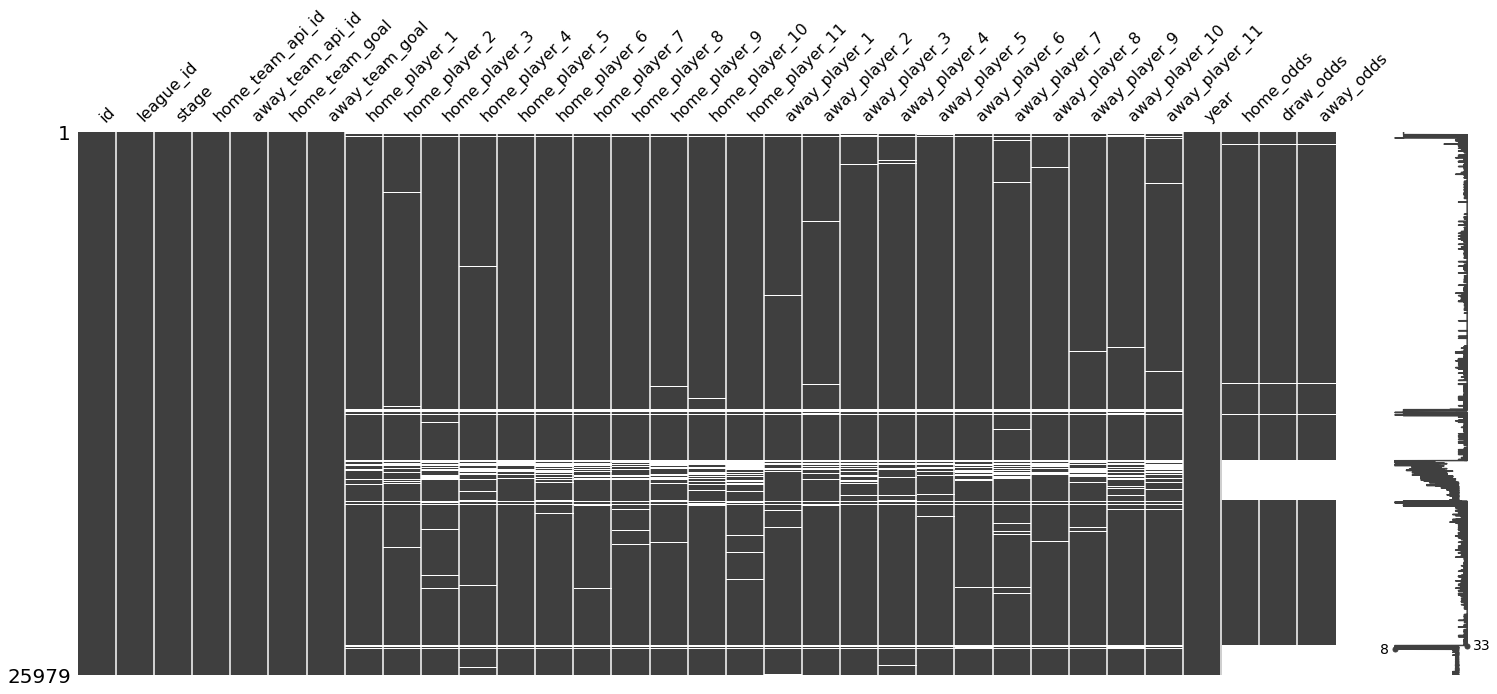

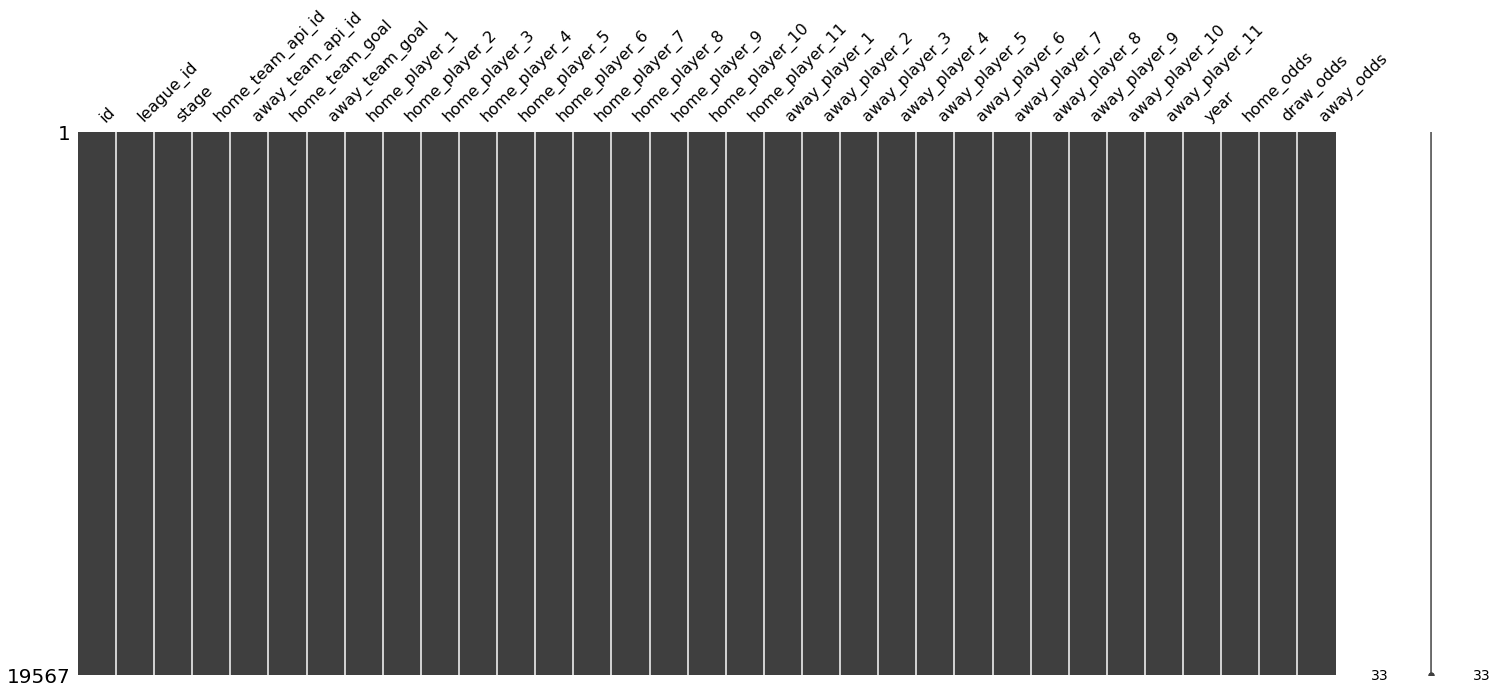

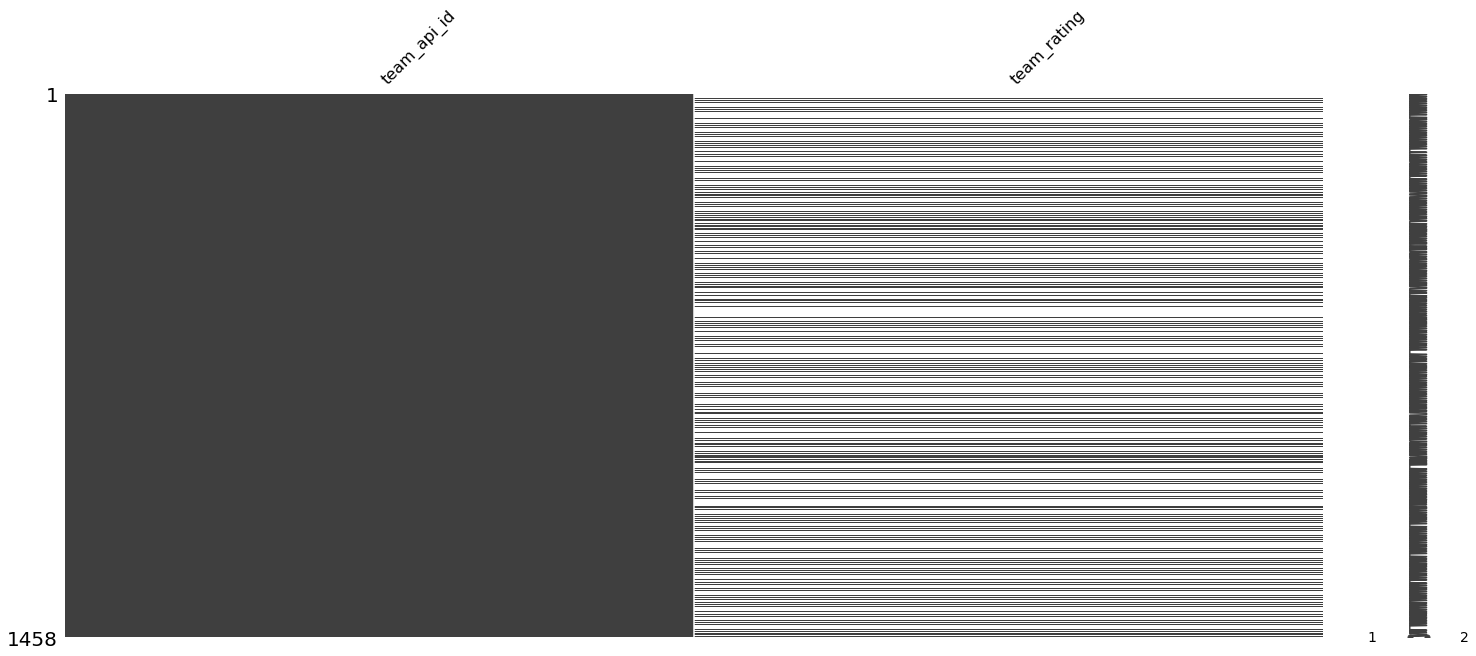

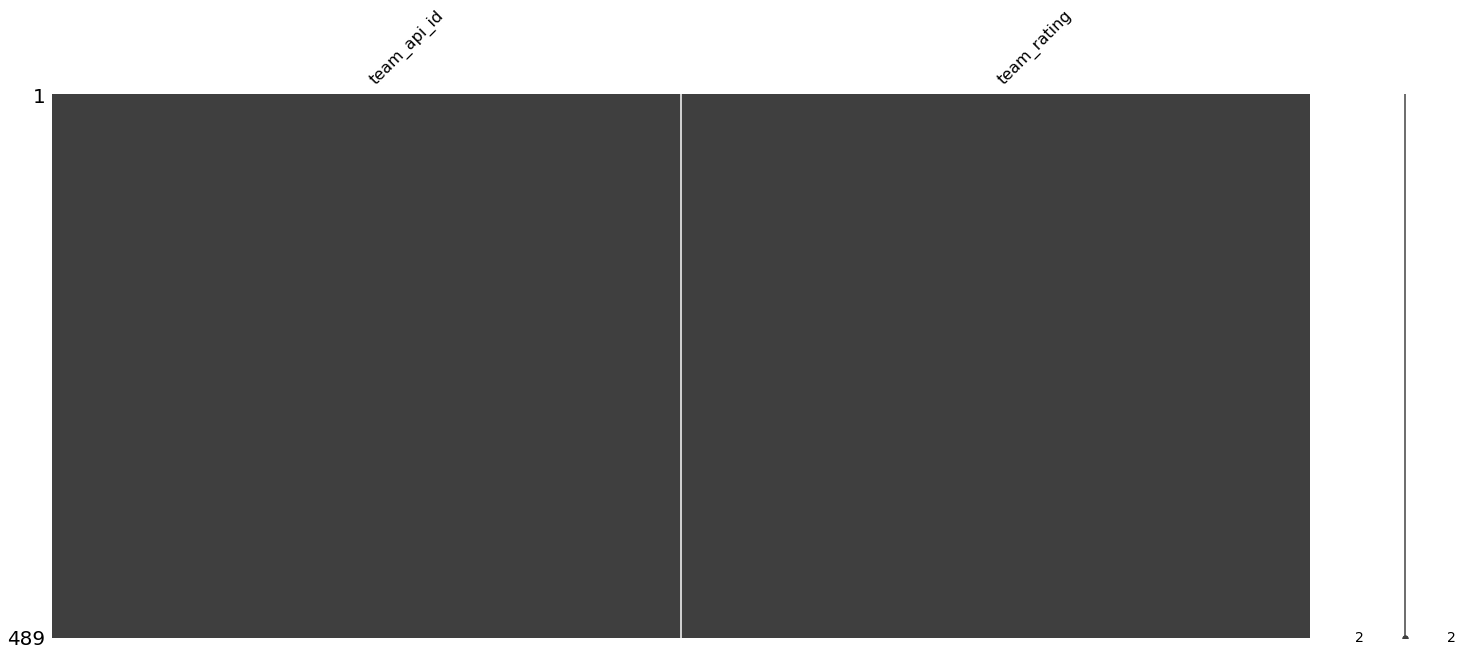

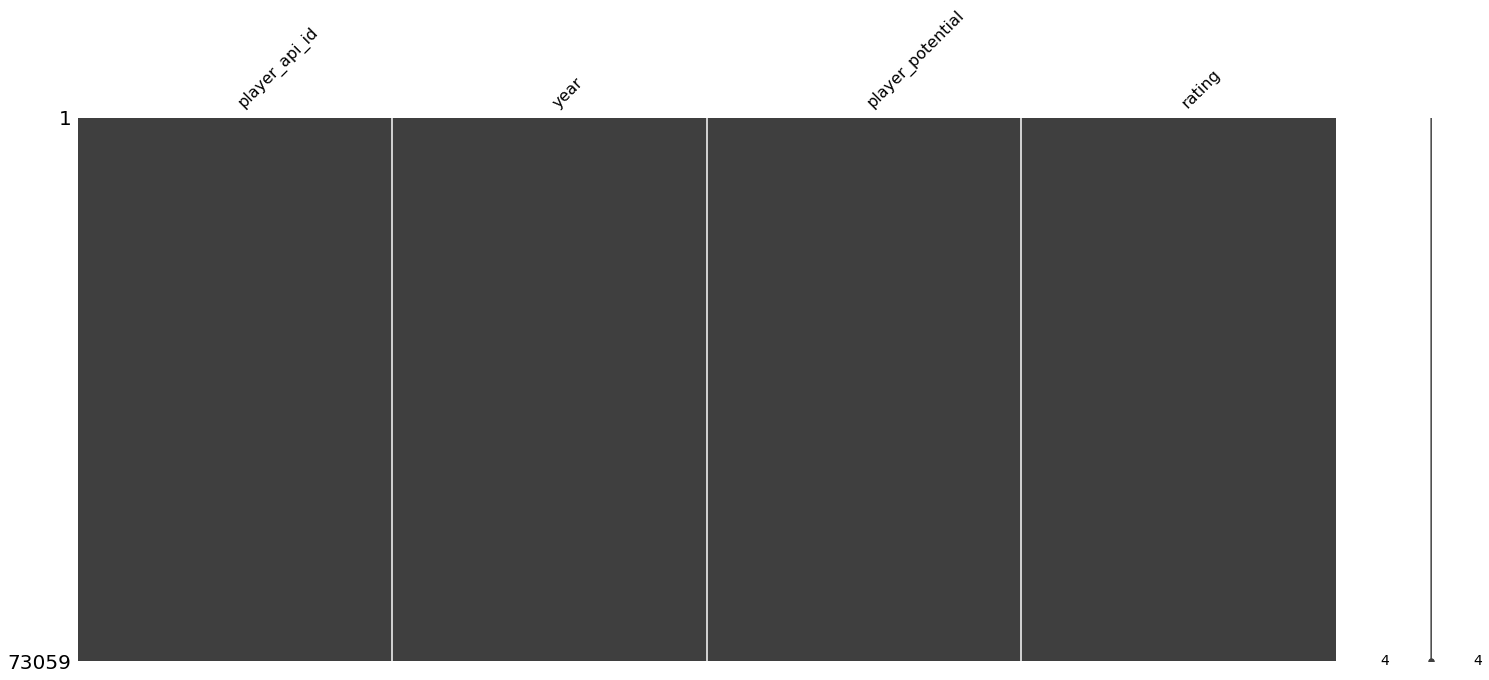

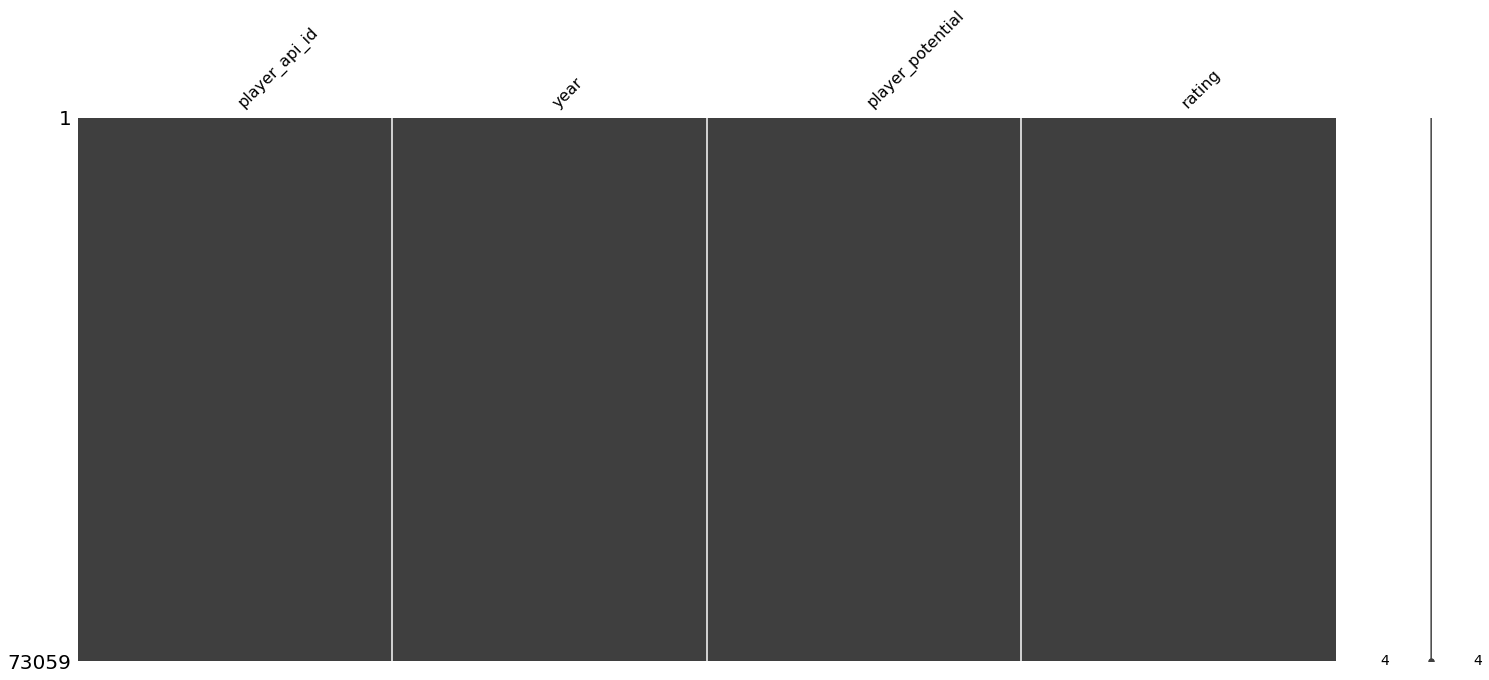

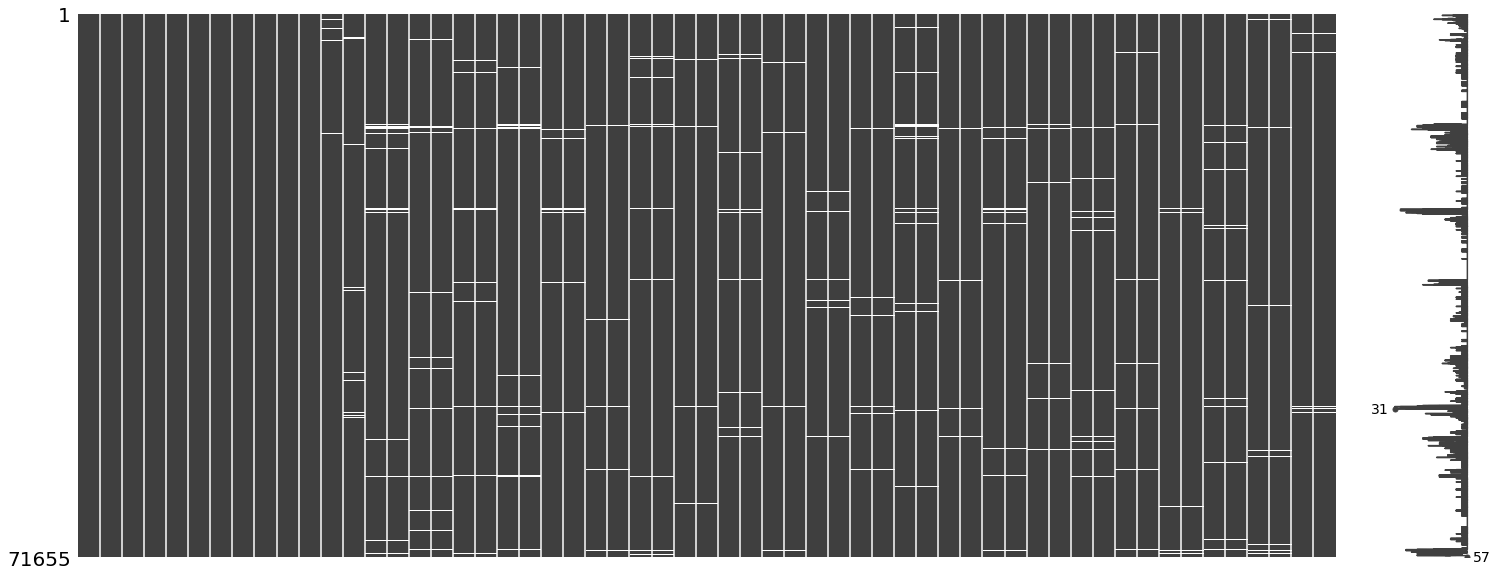

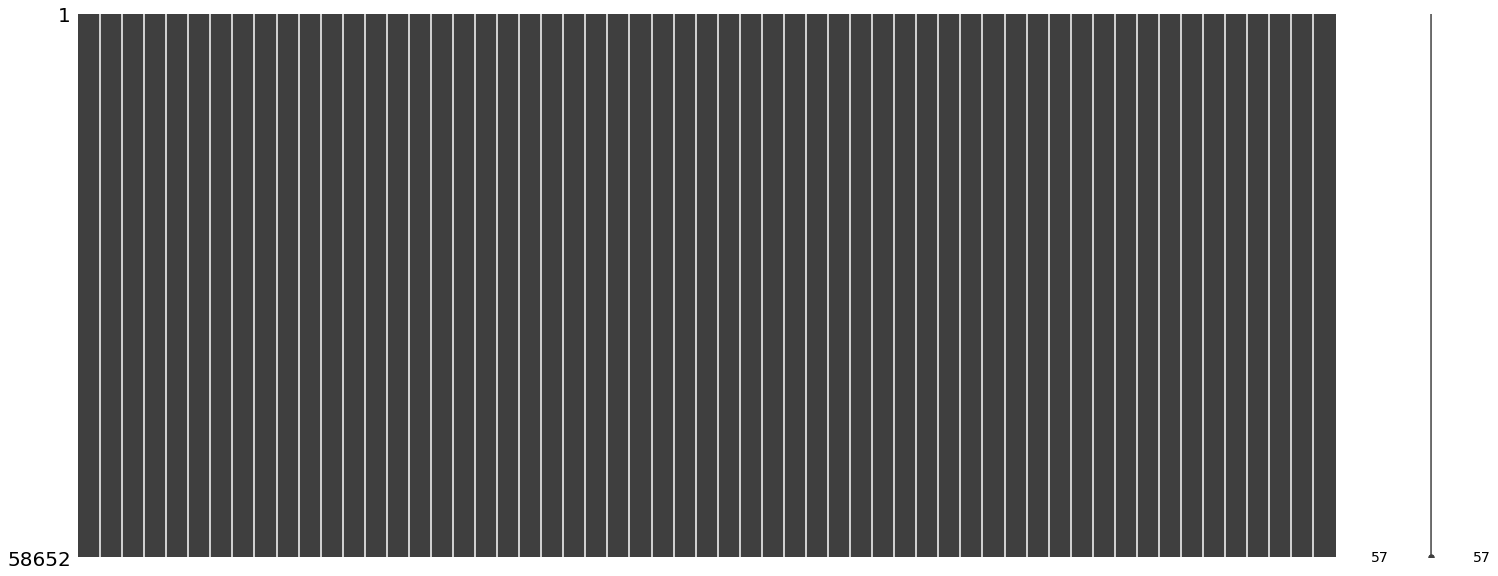

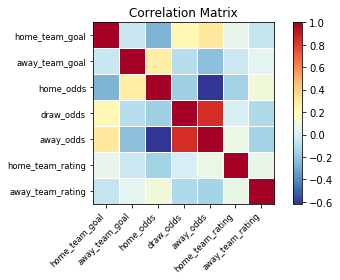

In [14]:
# Preprocess and clean up data
dataset = preprocess_data()

# Get information of a specific year
team_dataset = get_team_info('2009', dataset)

# Select relevant columns
X = team_dataset.iloc[:, [8, 9, 10, 11, 12]] # home_odds, draw_odds, away_odds, home_team_rating, away_team_rating
Y_home = team_dataset.iloc[:, 5] # home_team_goals
Y_away = team_dataset.iloc[:, 6] # away_team_goals

# Calculate PCA
print('\nPCA - Principal Component Analysis\n')
PCA_call(X)

# Correlation Matrix between columns
print('\n\nCorrelation Matrix')
dba = team_dataset.iloc[:, [5,6,8,9,10,11,12]]
corr = dba[:-1].corr()
fig=plot_corr(corr,xnames=corr.columns)
plt.show()

# Normalize data
X = preprocessing.scale(X)
Y_home = preprocessing.scale(Y_home)
Y_away = preprocessing.scale(Y_away)




Home Goals Prediction

Linear Regression
     regression score = 0.09687927910344707
     mean squared error = 0.88427721018228
     explained variance score = 0.09688967058163267
     mean absolute error = 0.7525048690874077
     max error = 3.697801199193816


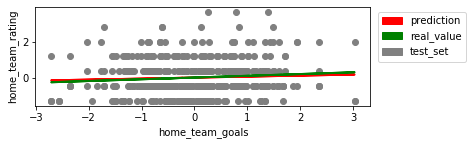


K-Nearest Neighbour
     regression score = 0.36111388446661563
     mean squared error = 0.6255558296871
     explained variance score = 0.3625353709530449
     mean absolute error = 0.5141226283971483
     max error = 3.187800404753584


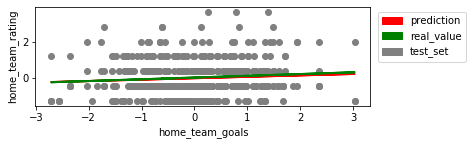


Neural Network
     regression score = 0.13977584942897647
     mean squared error = 0.8422756718982392
     explained variance score = 0.14004383045850222
     mean absolute error = 0.7276289084426467
     max error = 3.4833604471133155


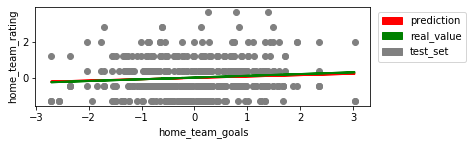


Support Vector Machines
     regression score = 0.09215990341639302
     mean squared error = 0.8888981166345286
     explained variance score = 0.12081629009420347
     mean absolute error = 0.7103689104913673
     max error = 3.9743298268521565


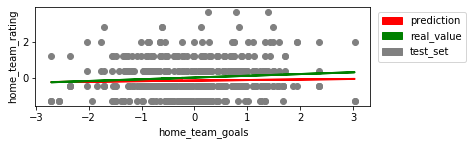


Decision Tree
     regression score = 0.886701366153573
     mean squared error = 0.11093467078877708
     explained variance score = 0.8874116328365166
     mean absolute error = 0.07581757395388634
     max error = 2.4624229453718725


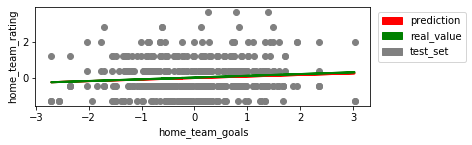

In [15]:
# Goals Prediction Home Team
print('\n\nHome Goals Prediction')
algorithms(X, Y_home, "home_team", 3)




Away Goals Prediction

Linear Regression
     regression score = 0.1000971795707728
     mean squared error = 1.0140714544979932
     explained variance score = 0.10952418966511712
     mean absolute error = 0.794440617672407
     max error = 3.550011946911979


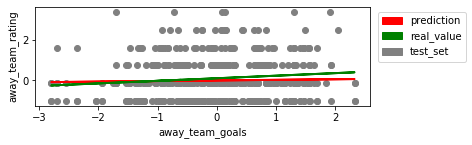


K-Nearest Neighbour
     regression score = 0.43114681943775823
     mean squared error = 0.6410222960890575
     explained variance score = 0.43751133344785087
     mean absolute error = 0.5086070968408088
     max error = 3.5349690174755457


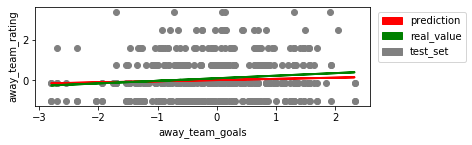


Neural Network
     regression score = 0.1339285812478569
     mean squared error = 0.9759479394610886
     explained variance score = 0.1451736957597849
     mean absolute error = 0.7843398684043995
     max error = 3.427185577809017


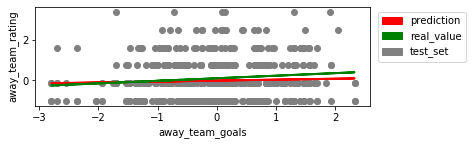


Support Vector Machines
     regression score = 0.06735261300206552
     mean squared error = 1.050970250116166
     explained variance score = 0.12044604762655808
     mean absolute error = 0.782044910827824
     max error = 3.615803409800914


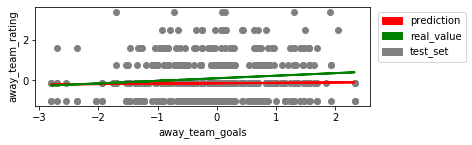


Decision Tree
     regression score = 0.8538703808759953
     mean squared error = 0.16466875316563284
     explained variance score = 0.8538731754757107
     mean absolute error = 0.09405289052520284
     max error = 2.6512267631066595


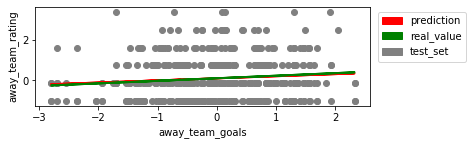

In [16]:
# Goals Prediction Away Team
print('\n\nAway Goals Prediction')
algorithms(X, Y_away, "away_team", 4)


### 5. Conclusões

Após a fase de experimentação descrita acima, foi-nos possível extrair as seguintes conclusões:

* Segundo o PCA, as duas componentes com maior variância são as odds da vitória da equipa de fora e o rating da equipa da casa. 

* Através da matriz de correlação, verifica-se uma forte correlação entre os golos da equipa da casa e as odds de um empate ou vitória da equipa de fora assim como entre os golos da equipa de fora e as odds de uma vitória da equipa da casa.

* Após serem testados diferentes tamanhos para o conjunto de teste, percebemos que a distribuição que apresenta melhores resultados consiste em 10% para o conjunto de teste e 90% para o conjunto de treino.

* Ao testar diferentes parametrizações para cada um dos algoritmos, concluímos que os valores que, em geral, apresentavam melhores resultados seriam: k = 5 no algoritmo K-Nearest Neighbours (ou seja, usando os 5 valores a uma menor distância) e um número máximo de iterações, max_iter, de 1000 no algoritmo de Neural Networks (permitindo que a função consiga convergir). Os restantes algoritmos mantiveram os seus parâmetros default.   

* O algoritmo que consegue obter uma regressão mais precisa para os dados utilizados é Decision Trees, seguido pelo K-Nearest Neighbour. 

* O uso de K-Fold Cross Validation neste conjunto de dados, método recomendado para datasets com mais de 1000 exemplos, como é este caso, não permitiu uma melhoria do modelo obtido.



### Referências

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict

https://scikit-learn.org/stable/supervised_learning.html#supervised-learning

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/

https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

https://towardsdatascience.com/https-medium-com-lorrli-classification-and-regression-analysis-with-decision-trees-c43cdbc58054

https://www.saedsayad.com/decision_tree_reg.htm

https://medium.com/@AI_with_Kain/understanding-of-multilayer-perceptron-mlp-8f179c4a135f

https://medium.com/@denzilsequeira/data-pre-processing-for-deep-learning-for-classification-or-regression-2bddb0b9183b

https://pandas.pydata.org/pandas-docs/stable/reference/frame.html
